In [26]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from IPython.display import Audio
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.layers as L
from tensorflow.keras.layers import Dense 
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences


## Dataset

In [ ]:
# audio_dir = "/kaggle/input/speech-emotion-recognition-en/Crema"
path = "../speech_emotion_dataset"

In [3]:
def load_and_listen(audio_path, sample_rate=22050):
    # Load the audio
    y, sr = librosa.load(audio_path, sr=sample_rate)

    # Plot the waveform
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of {audio_path}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # Play the audio
    return Audio(y, rate=sr)


Total audio files: 7442


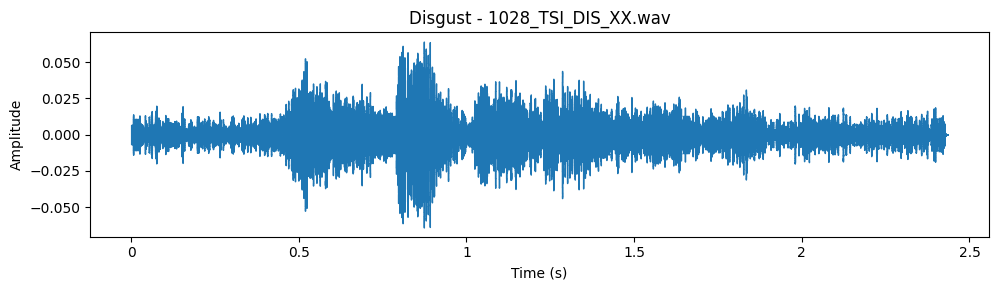

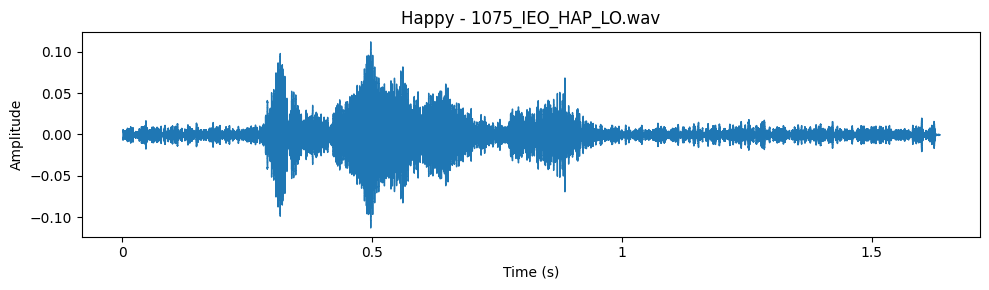

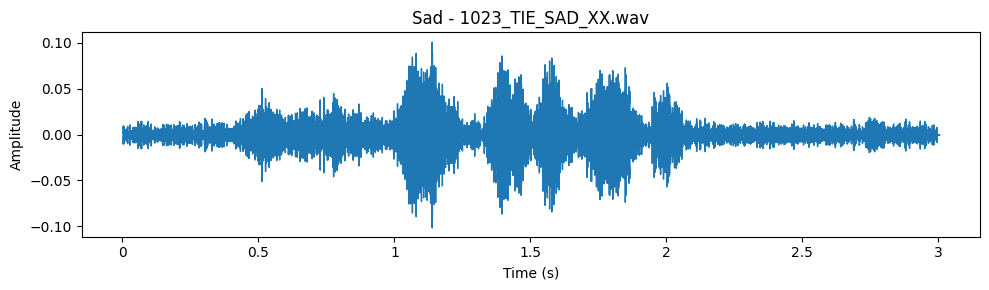

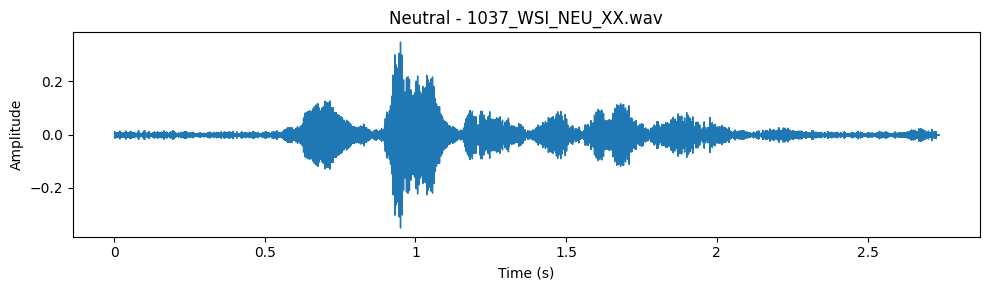

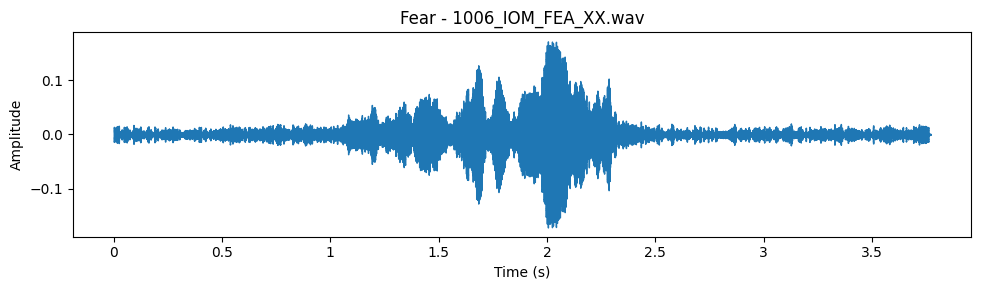

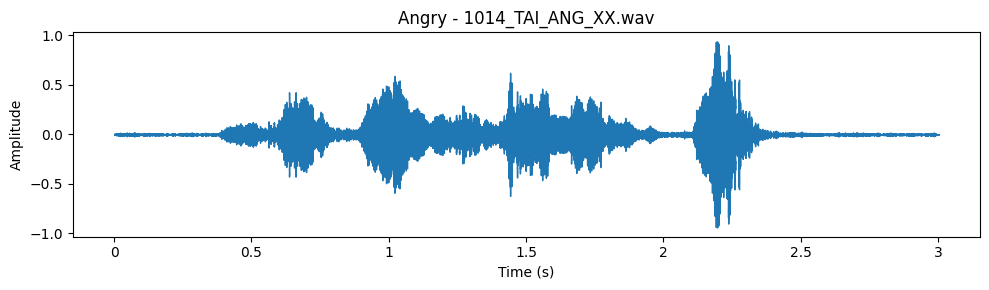

In [ ]:
# Locate the folder with .wav files
audio_dir = os.path.join(path, "Crema")  # Make sure this folder name matches what you see

# List all .wav files
audio_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]
print(f"Total audio files: {len(audio_files)}")

# Mapping of emotion codes to labels
emotion_map = {
    "ANG": "Angry",
    "DIS": "Disgust",
    "FEA": "Fear",
    "HAP": "Happy",
    "NEU": "Neutral",
    "SAD": "Sad"
}

# Extract a sample of one file per emotion
samples = {}
for file in audio_files:
    parts = file.split('_')
    emotion_code = parts[2]
    if emotion_code in emotion_map and emotion_code not in samples:
        samples[emotion_code] = file

# Plot and listen to one file per emotion
for code, filename in samples.items():
    filepath = os.path.join(audio_dir, filename)
    signal, sr = librosa.load(filepath, sr=None)
    
    # Plot waveform
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(f"{emotion_map[code]} - {filename}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    
    # Play audio (if running in Jupyter Notebook)
    try:
        from IPython.display import Audio, display
        display(Audio(filepath))
    except:
        pass

### Data Augmentation

In [5]:
def add_noise(data, random=False, rate=0.035, threshold=0.075):
    if random:
        rate = np.random.random() * threshold
    # noise = rate * np.random.uniform() * np.amax(data)
    noise = rate * np.amax(data) * np.random.normal(0, 1, size=data.shape)
    augmented_data = data + noise * np.random.normal(size=data.shape[0])
    return augmented_data

def shifting(data, rate=1000, wrap=False):
    shift_amount = int(np.random.uniform(low=-5, high=5) * rate)
    if wrap:
        return np.roll(data, shift_amount)
    else:
        if shift_amount > 0:
            return np.concatenate((np.zeros(shift_amount), data[:-shift_amount]))
        else:
            return np.concatenate((data[-shift_amount:], np.zeros(-shift_amount)))


def pitching(y, sr, n_steps=4):
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    return y_shifted

def stretching(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


In [6]:
def extract_features(filepath, sr=16000, frame_length=2048, hop_length=512, n_mels=128, augment = False):
    # Load audio
    signal, sr = librosa.load(filepath, sr=sr)  # Use desired sampling rate
    # Trim silent edges
    signal, _ = librosa.effects.trim(signal)
    
    if augment:
        # Randomly choose one augmentation (or apply all if desired)
        aug_type = np.random.choice(['noise', 'shift', 'pitch', 'stretch'])
        if aug_type == 'noise':
            signal = add_noise(signal, random=True)
        elif aug_type == 'shift':
            signal = shifting(signal)
        elif aug_type == 'pitch':
            signal = pitching(signal, sr)
        elif aug_type == 'stretch':
            try:
                signal = stretching(signal, rate=np.random.uniform(0.8, 1.2))
            except:
                pass  # stretching can sometimes result in shape mismatch    

    # --- Zero Crossing Rate ---
    zcr = librosa.feature.zero_crossing_rate(
        y=signal, frame_length=frame_length, hop_length=hop_length
    )[0]  # shape: (frames,)

    # --- Energy (normalized) ---
    energy = np.array([
        np.sum(signal[i:i+frame_length]**2) / frame_length
        for i in range(0, len(signal) - frame_length + 1, hop_length)
    ])
    
    # --- Mel Spectrogram ---
    mel_spec = librosa.feature.melspectrogram(
        y=signal, sr=sr, n_mels=n_mels,
        n_fft=frame_length, hop_length=hop_length
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    return zcr, energy, mel_spec_db

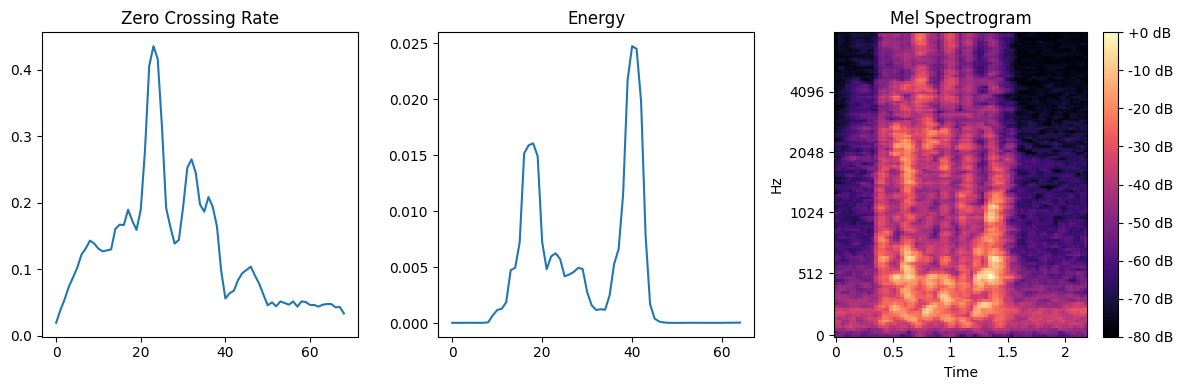

In [7]:
# Test on a sample
test_file = os.path.join(audio_dir, random.choice(audio_files))
zcr, energy, mel_spec = extract_features(test_file, augment=True)
fs1 = zcr , energy
fs2 = mel_spec
# Plot features
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(zcr)
plt.title("Zero Crossing Rate")

plt.subplot(1, 3, 2)
plt.plot(energy)
plt.title("Energy")

plt.subplot(1, 3, 3)
librosa.display.specshow(mel_spec, sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")

plt.tight_layout()
plt.show()

In [8]:
# Prepare containers
zcr_list = []
energy_list = []
mel_spec_list = []
labels = []

valid_emotions = {"ANG", "DIS", "FEA", "HAP", "NEU", "SAD"}

# Loop through files
for file in tqdm(audio_files):
    parts = file.split('_')
    emotion_code = parts[2]

    if emotion_code not in valid_emotions:
        continue 

    filepath = os.path.join(audio_dir, file)
    
    try:
        # Original (non-augmented) data
        zcr, energy, mel_spec = extract_features(filepath, augment=False)
        zcr_list.append(zcr)
        energy_list.append(energy)
        mel_spec_list.append(mel_spec)
        labels.append(emotion_code)

        # Augmented version (1 sample per original only for 1D features)
        zcr_aug, energy_aug, mel_spec_aug = extract_features(filepath, augment=True)
        zcr_list.append(zcr_aug)
        energy_list.append(energy_aug)
        mel_spec_list.append(mel_spec)
        labels.append(emotion_code)  # Same label
        
    except Exception as e:
        print(f"Failed for {file}: {e}")

100%|██████████| 7442/7442 [03:56<00:00, 31.50it/s]


In [9]:
X =zcr_list, energy_list, mel_spec_list
print(len(zcr_list), len(energy_list), len(mel_spec_list))

le = LabelEncoder()
label_array = le.fit_transform(labels)

# Get mapping
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_map)
label_array.shape
print(label_array.shape)

# Convert to DataFrame
df = pd.DataFrame({
    'zcr': zcr_list,
    'energy': energy_list,
    'mel_spec': mel_spec_list,
    'label': label_array
})

X = df.drop(columns=['label'])
y = df['label']

print("Shape of features:", X.shape)
print("Shape of labels:", y.shape)


14884 14884 14884
Label mapping: {'ANG': 0, 'DIS': 1, 'FEA': 2, 'HAP': 3, 'NEU': 4, 'SAD': 5}
(14884,)
Shape of features: (14884, 3)
Shape of labels: (14884,)


### Splitting the data

In [10]:
# 1. Train+Val (70%) and Test (30%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# 2. From Train+Val, get 5% as validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.05,  # 5% of 70% ≈ 3.5% of total data
    stratify=y_temp,
    random_state=42
)

# Show shapes
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (9897, 3)
Validation shape: (521, 3)
Test shape: (4466, 3)


### Create the feature space

In [11]:
"""First feature Space""" 
X_train1 = X_train[X_train.columns[0:2]]
X_val1   = X_val[X_val.columns[0:2]]
X_test1  = X_test[X_test.columns[0:2]]

"""Second feature space"""
X_train2 = X_train[X_train.columns[2:]]
X_val2   = X_val[X_val.columns[2:]]
X_test2  = X_test[X_test.columns[2:]]

print("Train shape1:", X_train1.shape)
print("Validation shape1:", X_val1.shape)
print("Test shape1:", X_test1.shape)

print("Train shape2:", X_train2.shape)
print("Validation shape2:", X_val2.shape)
print("Test shape2:", X_test2.shape)

Train shape1: (9897, 2)
Validation shape1: (521, 2)
Test shape1: (4466, 2)
Train shape2: (9897, 1)
Validation shape2: (521, 1)
Test shape2: (4466, 1)


### Prepare Data for Model Input

In [12]:

# Pad 1D features
def stack_and_pad_1d(features1, features2, max_len=400):
    x1 = pad_sequences(features1, maxlen=max_len, padding='post', dtype='float32')
    x2 = pad_sequences(features2, maxlen=max_len, padding='post', dtype='float32')
    return np.concatenate([x1, x2], axis=-1)

X_train1_padded = stack_and_pad_1d(X_train1['zcr'], X_train1['energy'])
X_val1_padded = stack_and_pad_1d(X_val1['zcr'], X_val1['energy'])
X_test1_padded = stack_and_pad_1d(X_test1['zcr'], X_test1['energy'])

# Pad 2D mel spectrograms
def pad_melspec_2d(mels, max_time=400, max_freq=None):
    padded = []
    for m in mels:
        # Determine the frequency dimension size if not provided
        if max_freq is None:
            max_freq = m.shape[0]
        
        # Pad time dimension
        if m.shape[1] < max_time:
            pad_width_time = max_time - m.shape[1]
            m_padded = np.pad(m, ((0, 0), (0, pad_width_time)), mode='constant')
        else:
            m_padded = m[:, :max_time]
        
        # Pad frequency dimension if necessary
        if m.shape[0] < max_freq:
            pad_width_freq = max_freq - m.shape[0]
            m_padded = np.pad(m_padded, ((0, pad_width_freq), (0, 0)), mode='constant')
        else:
            m_padded = m_padded[:max_freq, :]
        
        padded.append(m_padded)
    
    return np.array(padded)[..., np.newaxis]  # Add channel dimension for 2D CNNs

# Apply the function to pad mel spectrograms
X_train2_padded = pad_melspec_2d(X_train2['mel_spec'])
X_val2_padded = pad_melspec_2d(X_val2['mel_spec'])
X_test2_padded = pad_melspec_2d(X_test2['mel_spec'])

# Convert labels
y_train_arr = tf.keras.utils.to_categorical(y_train)
y_val_arr = tf.keras.utils.to_categorical(y_val)
y_test_arr = tf.keras.utils.to_categorical(y_test)

# Print shapes to verify
print("Train shape:", X_train1_padded.shape)
print("Validation shape:", X_val1_padded.shape)
print("Test shape:", X_test1_padded.shape)

print("Train 2D shape:", X_train2_padded.shape)
print("Validation 2D shape:", X_val2_padded.shape)
print("Test 2D shape:", X_test2_padded.shape)

Train shape: (9897, 800)
Validation shape: (521, 800)
Test shape: (4466, 800)
Train 2D shape: (9897, 128, 400, 1)
Validation 2D shape: (521, 128, 400, 1)
Test 2D shape: (4466, 128, 400, 1)


## Define CNN Models

### 1D CNN (ZCR + Energy)

In [13]:
def build_1d_cnn():
    inputs = tf.keras.Input(shape=(800, 1))  # Assuming a flattened time-series input

    # Block 1
    x = L.Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling1D(pool_size=2)(x)

    # Block 2
    x = L.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling1D(pool_size=2)(x)

    # Block 3
    x = L.Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling1D(pool_size=2)(x)

    # Block 4
    x = L.Conv1D(512, kernel_size=3, padding='same', activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling1D(pool_size=2)(x)

    # Global Pooling and Output
    x = L.GlobalAveragePooling1D()(x)
    x = L.Dense(128, activation='relu')(x)
    x = L.Dropout(0.2)(x)
    outputs = L.Dense(6, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

### 2D CNN (Mel Spectrogram)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers as L

def build_2d_cnn():
    inputs = tf.keras.Input(shape=(128, 400, 1))  # Mel-spectrogram shape

    # Block 1
    x = L.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)

    # Block 2
    x = L.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)

    # Block 3
    x = L.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)

    # Block 4
    x = L.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)

    # Global Pooling and Output
    x = L.GlobalAveragePooling2D()(x)
    x = L.Dense(128, activation='relu')(x)
    x = L.Dropout(0.2)(x)
    outputs = L.Dense(6, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

### Train the 1D CNN Model

In [15]:
callbacks = [
    EarlyStopping(monitor= 'val_accuracy', patience=10, restore_best_weights=True, mode ='auto'),
    ReduceLROnPlateau(monitor='val_accuracy',patience=5)
]

In [16]:
scaler = StandardScaler()
X_train1_scaled = scaler.fit_transform(X_train1_padded)
X_val1_scaled = scaler.transform(X_val1_padded)
X_test1_scaled = scaler.transform(X_test1_padded)


In [17]:
# Train 1D CNN
model_1d = build_1d_cnn()
model_1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1d.summary()
history_1D = model_1d.fit(X_train1_scaled, y_train_arr, epochs=100, batch_size=128, 
             validation_data=(X_val1_scaled, y_val_arr), callbacks=callbacks)

I0000 00:00:1747249860.804964      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 800, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 800, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 800, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 400, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 400, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 400, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 200, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 200, 256)            │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 200, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 100, 512)            │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 50, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 587,526 (2.24 MB)

 Trainable params: 585,606 (2.23 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/100


I0000 00:00:1747249866.963235     108 service.cc:148] XLA service 0x7b6ee4014b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747249866.963817     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747249867.471934     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2399 - loss: 1.7728

I0000 00:00:1747249871.862768     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.3337 - loss: 1.6032 - val_accuracy: 0.1708 - val_loss: 2.3702 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4147 - loss: 1.4337 - val_accuracy: 0.1708 - val_loss: 3.0847 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4399 - loss: 1.3823 - val_accuracy: 0.1881 - val_loss: 4.2316 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4622 - loss: 1.3496 - val_accuracy: 0.1939 - val_loss: 5.2284 - learning_rate: 0.0010
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4717 - loss: 1.3222 - val_accuracy: 0.1727 - val_loss: 3.6441 - learning_rate: 0.0010
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4941 - loss: 1.2758 - val_accuracy: 0.1785 - val_loss: 2.7908 - learning_rate: 0.0010
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5144 - loss: 1.2269 - val_accurac

In [ ]:
model_1d.save("./model_1d.h5")
# loaded_model = tf.keras.models.load_model("./model_1d.h5")
model_1d.save("/kaggle/working/model_1d.h5")
# loaded_model = tf.keras.models.load_model("C:\Users\Kimo Store\Desktop\Term 8\Pattern\Labs\Lab 3\Speech-Emotion-Recognition\model_1d.h5")

### Train the 2D CNN Model

In [19]:
# # Train 2D CNN
model_2d = build_2d_cnn()
model_2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2d.summary()
# history_2D = model_2d.fit(X_train2_padded, y_train_arr, epochs=1, batch_size=32, 
#              validation_data=(X_val2_padded, y_val_arr), callbacks=callbacks)


class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size
        return self.X[start:end], self.y[start:end]

train_gen = DataGenerator(X_train2_padded, y_train_arr)
val_gen = DataGenerator(X_val2_padded, y_val_arr)


history_2D = model_2d.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 400, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 400, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 400, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 200, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 200, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 200, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 100, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 100, 256)        │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 100, 256)        │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 50, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 50, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 50, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 25, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,620,102 (6.18 MB)

 Trainable params: 1,618,182 (6.17 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/310 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.3761 - loss: 1.5209

E0000 00:00:1747250000.027912     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747250000.263140     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3943 - loss: 1.4833

E0000 00:00:1747250015.935794     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747250016.170386     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


310/310 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step - accuracy: 0.3944 - loss: 1.4830 - val_accuracy: 0.2841 - val_loss: 4.4188 - learning_rate: 0.0010
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4861 - loss: 1.2899 - val_accuracy: 0.1708 - val_loss: 5.1053 - learning_rate: 0.0010
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5450 - loss: 1.1762 - val_accuracy: 0.1708 - val_loss: 7.7845 - learning_rate: 0.0010
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5810 - loss: 1.0849 - val_accuracy: 0.1766 - val_loss: 6.6020 - learning_rate: 0.0010
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6167 - loss: 1.0098 - val_accuracy: 0.1708 - val_loss: 32.0985 - learning_rate: 0.0010
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6622 - loss: 0.9040 - val_accuracy: 0.3647 - val_loss: 2.4538 - learning_rate: 0.0010
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6961 - loss: 0.795

In [ ]:
model_2d.save("./model_2d.h5")
# loaded_model = tf.keras.models.load_model("./model_2d.h5")
# model_2d.save("/kaggle/working/model_2d.h5")
# loaded_model = tf.keras.models.load_model("C:\Users\Kimo Store\Desktop\Term 8\Pattern\Labs\Lab 3\Speech-Emotion-Recognition\model_1d.h5")

### 1D Model Plotting

Train accuracy 1D: [0.37425482273101807, 0.4169950485229492, 0.44468021392822266, 0.46034151315689087, 0.4742851257324219, 0.4972213804721832, 0.5130847692489624, 0.5366272330284119, 0.5544103980064392, 0.5901788473129272, 0.6303930282592773, 0.661109447479248, 0.7053652405738831, 0.7556835412979126, 0.7914519309997559, 0.8200464844703674, 0.8615742325782776, 0.8888552188873291, 0.9030008912086487, 0.9283621311187744, 0.9385672211647034, 0.9607961773872375, 0.9644336700439453, 0.9734262824058533, 0.978680431842804, 0.9735273122787476, 0.9717085957527161, 0.9858543276786804, 0.996261477470398, 0.9972718954086304, 0.9985854029655457, 0.9984843730926514, 0.9990906119346619, 0.9989895820617676, 0.998787522315979, 0.9993937611579895, 0.9992927312850952, 0.9993937611579895, 0.9990906119346619, 0.9992927312850952, 0.9992927312850952, 0.9994947910308838]
Validation accuracy 1D: [0.17082533240318298, 0.17082533240318298, 0.18809980154037476, 0.19385796785354614, 0.1727447211742401, 0.1785028725

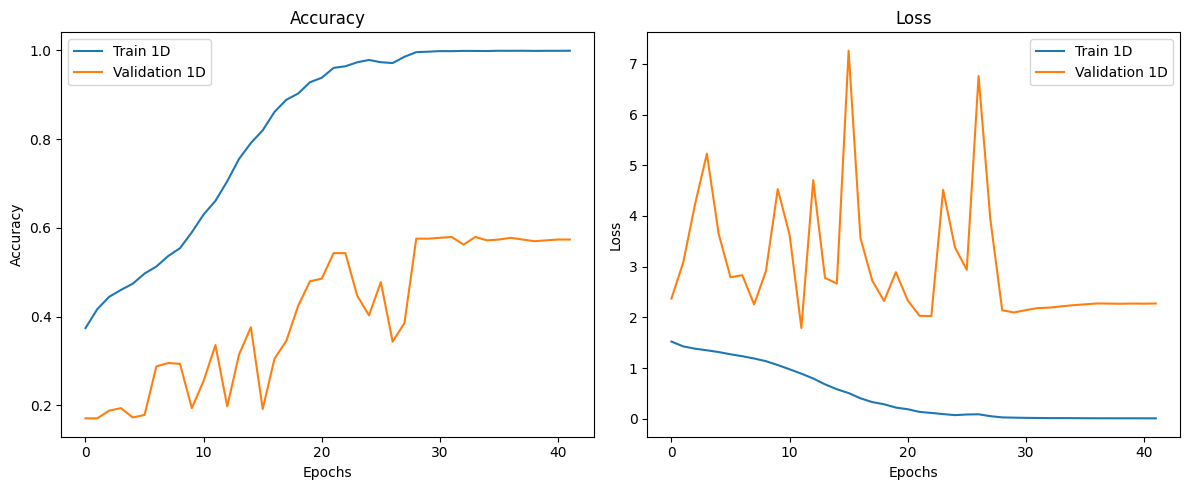

In [21]:
# train accuracy
train_acc_1d = history_1D.history['accuracy']
# validation accuracy
val_acc_1d = history_1D.history['val_accuracy']
# train loss
train_loss_1d = history_1D.history['loss']
# validation loss
val_loss_1d = history_1D.history['val_loss']

print("Train accuracy 1D:", train_acc_1d)
print("Validation accuracy 1D:", val_acc_1d)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_1d, label='Train 1D')
plt.plot(val_acc_1d, label='Validation 1D')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_loss_1d, label='Train 1D')
plt.plot(val_loss_1d, label='Validation 1D')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


### 2D Model Plotting

Train accuracy 2D: [0.43083763122558594, 0.5063150525093079, 0.5518844127655029, 0.5836111903190613, 0.620491087436676, 0.6596948504447937, 0.6995049118995667, 0.7518439888954163, 0.8048903942108154, 0.8558148741722107, 0.9051227569580078, 0.9410932660102844, 0.9600889086723328, 0.9729210734367371, 0.9756491780281067, 0.9698898792266846, 0.9767606258392334, 0.983631432056427, 0.9732242226600647, 0.9911084175109863, 0.9986864924430847, 0.9994947910308838, 0.9997979402542114, 0.9998989701271057, 0.9997979402542114, 0.9997979402542114, 0.9998989701271057, 1.0, 0.9997979402542114, 1.0, 0.9998989701271057, 0.9997979402542114, 0.9998989701271057, 0.9997979402542114, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Validation accuracy 2D: [0.28406909108161926, 0.17082533240318298, 0.17082533240318298, 0.17658349871635437, 0.17082533240318298, 0.3646833002567291, 0.3685220777988434, 0.17466410994529724, 0.5086372494697571, 0.17082533240318298, 0.27063339948654175, 0.25335893034935, 0.40882918

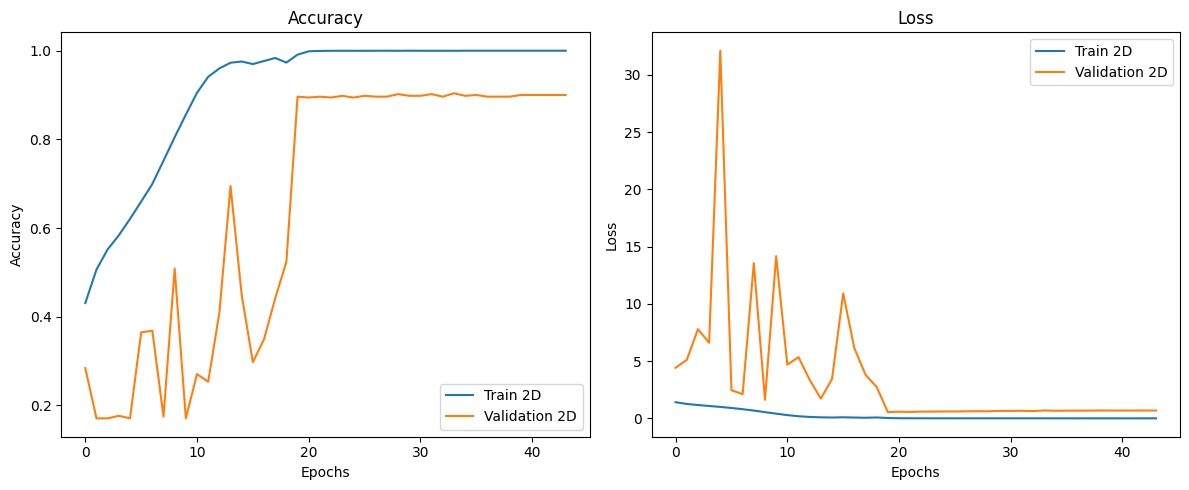

In [22]:
# train accuracy
train_acc_2d = history_2D.history['accuracy']
# validation accuracy
val_acc_2d = history_2D.history['val_accuracy']
# train loss
train_loss_2d = history_2D.history['loss']
# validation loss
val_loss_2d = history_2D.history['val_loss']

print("Train accuracy 2D:", train_acc_2d)
print("Validation accuracy 2D:", val_acc_2d)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_2d, label='Train 2D')
plt.plot(val_acc_2d, label='Validation 2D')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_loss_2d, label='Train 2D')
plt.plot(val_loss_2d, label='Validation 2D')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


## Evaluation

In [ ]:
# Evaluate the model on the test set (1D CNN Model)
test_loss_1d, test_acc_1d = model_1d.evaluate(X_test1_scaled, y_test_arr)
print(f"Test accuracy 1D: {test_acc_1d:.4f}")

#f1 score
from sklearn.metrics import f1_score
y_pred_1d = model_1d.predict(X_test1_scaled)
y_pred_1d_classes = np.argmax(y_pred_1d, axis=1)
f1_1d = f1_score(y_test, y_pred_1d_classes, average='weighted')
print(f"F1 Score 1D: {f1_1d:.4f}")

# Evaluate the model on the test set (2D CNN Model)
test_loss_2d, test_acc_2d = model_2d.evaluate(X_test2_padded, y_test_arr)
print(f"Test accuracy 2D: {test_acc_2d:.4f}")

#f1 score
y_pred_2d = model_2d.predict(X_test2_padded)
y_pred_2d_classes = np.argmax(y_pred_2d, axis=1)
f1_2d = f1_score(y_test, y_pred_2d_classes, average='weighted')
print(f"F1 Score 2D: {f1_2d:.4f}")

# # Save the models
# model_1d.save("C:\Users\Kimo Store\Desktop\Term 8\Pattern\Labs\Lab 3\Speech-Emotion-Recognition\model_1d.h5")
# model_2d.save("C:\Users\Kimo Store\Desktop\Term 8\Pattern\Labs\Lab 3\Speech-Emotion-Recognition\model_2d.h5")
# # Load the models
# loaded_model = tf.keras.models.load_model("C:\Users\Kimo Store\Desktop\Term 8\Pattern\Labs\Lab 3\Speech-Emotion-Recognition\model_1d.h5")
# loaded_model2 = tf.keras.models.load_model("C:\Users\Kimo Store\Desktop\Term 8\Pattern\Labs\Lab 3\Speech-Emotion-Recognition\model_2d.h5")


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5669 - loss: 2.1667
Test accuracy 1D: 0.5605
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1 Score 1D: 0.5575
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8781 - loss: 0.7625
Test accuracy 2D: 0.8766
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
F1 Score 2D: 0.8764


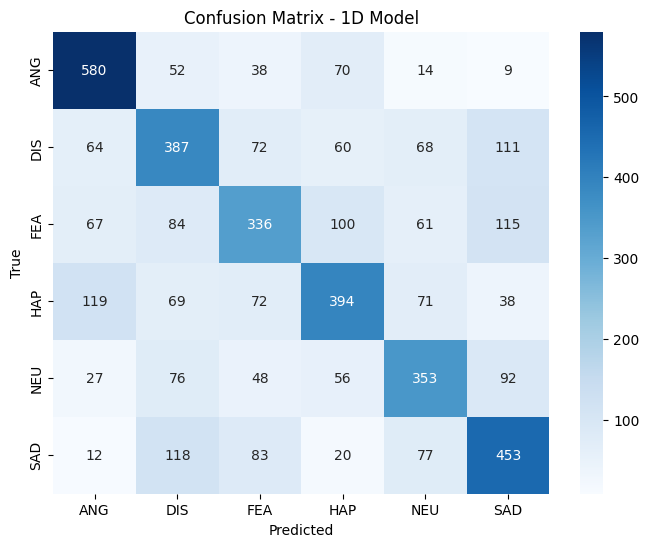

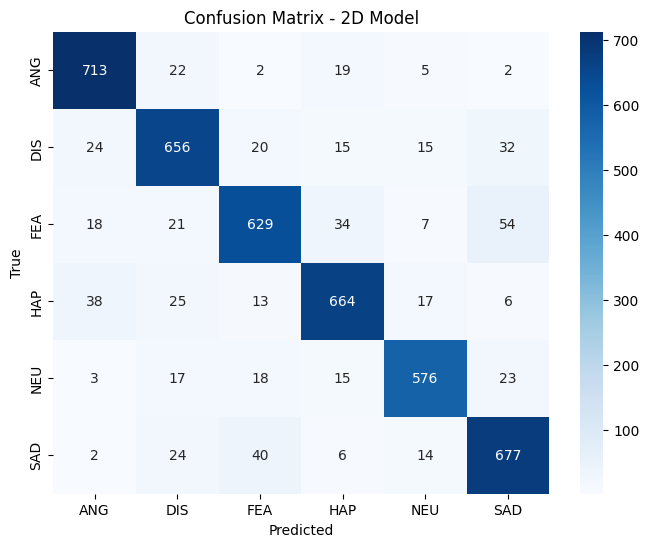

Most confusing classes for 1D model: HAP and ANG
Most confusing classes for 2D model: FEA and SAD


In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for 1D model
conf_matrix_1d = confusion_matrix(y_test, y_pred_1d_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1d, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - 1D Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Confusion matrix for 2D model
conf_matrix_2d = confusion_matrix(y_test, y_pred_2d_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_2d, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - 2D Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Find the most confusing classes for 1D model
confusion_1d = conf_matrix_1d.copy()
np.fill_diagonal(confusion_1d, 0)  # Ignore diagonal (correct predictions)
most_confusing_1d = np.unravel_index(np.argmax(confusion_1d), confusion_1d.shape)
print(f"Most confusing classes for 1D model: {le.classes_[most_confusing_1d[0]]} and {le.classes_[most_confusing_1d[1]]}")

# Find the most confusing classes for 2D model
confusion_2d = conf_matrix_2d.copy()
np.fill_diagonal(confusion_2d, 0)  # Ignore diagonal (correct predictions)
most_confusing_2d = np.unravel_index(np.argmax(confusion_2d), confusion_2d.shape)
print(f"Most confusing classes for 2D model: {le.classes_[most_confusing_2d[0]]} and {le.classes_[most_confusing_2d[1]]}")